In [1]:
import ROOT
import numpy as np
from array import array

# Function to rotate a 2D histogram
def RotateHistogram(hist, angle_degrees):
    # Clone the original histogram
    rotated_hist = hist.Clone(hist.GetName() + "_rotated")
    
    # Convert angle from degrees to radians
    angle_radians = ROOT.TMath.DegToRad() * angle_degrees
    
    # Rotation matrix
    rotation_matrix = ROOT.TMatrixD(2, 2)
    rotation_matrix[0][0] = ROOT.TMath.Cos(angle_radians)
    rotation_matrix[0][1] = -ROOT.TMath.Sin(angle_radians)
    rotation_matrix[1][0] = ROOT.TMath.Sin(angle_radians)
    rotation_matrix[1][1] = ROOT.TMath.Cos(angle_radians)
    
    # Get the bin contents and errors of the original histogram
    for binx in range(1, hist.GetNbinsX() + 1):
        for biny in range(1, hist.GetNbinsY() + 1):
            content = hist.GetBinContent(binx, biny)
            error = hist.GetBinError(binx, biny)
            
            # Get the center coordinates of the bin
            x_center = hist.GetXaxis().GetBinCenter(binx)
            y_center = hist.GetYaxis().GetBinCenter(biny)
            
            # Apply rotation to the coordinates
            x_rotated = rotation_matrix[0][0] * x_center + rotation_matrix[0][1] * y_center
            y_rotated = rotation_matrix[1][0] * x_center + rotation_matrix[1][1] * y_center
            
            # Set the bin content and error in the rotated histogram
            rotated_hist.Fill(x_rotated, y_rotated, content)
            rotated_hist.SetBinError(rotated_hist.FindBin(x_rotated, y_rotated), error)
    
    return rotated_hist

# Function to calculate ellipse parameters
def calculate_ellipse_parameters(hist, angle_degrees, confidence_level=0.99):
    # Convert angle from degrees to radians
    angle_radians = ROOT.TMath.DegToRad() * angle_degrees

    # Rotate the covariance matrix
    covariance_matrix = np.array([[hist.GetCovariance(1, 1), hist.GetCovariance(1, 2)],
                                  [hist.GetCovariance(2, 1), hist.GetCovariance(2, 2)]])
    
    rotation_matrix = np.array([[ROOT.TMath.Cos(angle_radians), -ROOT.TMath.Sin(angle_radians)],
                                [ROOT.TMath.Sin(angle_radians), ROOT.TMath.Cos(angle_radians)]])
    
    rotated_covariance_matrix = np.dot(rotation_matrix, np.dot(covariance_matrix, rotation_matrix.T))

    # Perform Singular Value Decomposition (SVD) to get principal components
    singular_values, principal_components = np.linalg.eig(rotated_covariance_matrix)
    ellipse_width = np.sqrt(confidence_level * singular_values[0])
    ellipse_height = np.sqrt(confidence_level * singular_values[1])

    # Calculate the center of the ellipse
    center_x = hist.GetMean(1)
    center_y = hist.GetMean(2)

    # Draw the ellipse
    ellipse = ROOT.TEllipse(center_x, center_y, ellipse_width, ellipse_height, 0, 360, angle_degrees)
    ellipse.SetLineColor(ROOT.kRed)
    ellipse.SetLineWidth(2)
    ellipse.SetFillStyle(0)
    ellipse.Draw()

# Example usage
def RotatedHist():
    # Create a unique name for the histogram
    hist_name = "hist_" + str(ROOT.TUUID().AsString())

    # Create a 2D histogram
    hist = ROOT.TH2D(hist_name, "2D Histogram", 50, -5, 5, 50, -5, 5)
    
    # Fill histogram with random Gaussian-distributed data
    rng = ROOT.TRandom3()
    for i in range(10000):
        x = rng.Gaus(0, 1)
        y = rng.Gaus(0, 1)
        hist.Fill(x, y)
    
    # Rotate the histogram
    rotated_hist = RotateHistogram(hist, 45) # Rotate by 45 degrees
    
    # Create a canvas
    canvas = ROOT.TCanvas("canvas", "Canvas", 800, 600)
    
    # Draw the rotated histogram
    rotated_hist.Draw("COLZ")
    
    # Calculate and draw the ellipse
    calculate_ellipse_parameters(rotated_hist, 45)

    # Update the canvas
    canvas.Draw()

# Call the function to display the rotated histogram with the ellipse
RotatedHist()

Welcome to JupyROOT 6.26/06


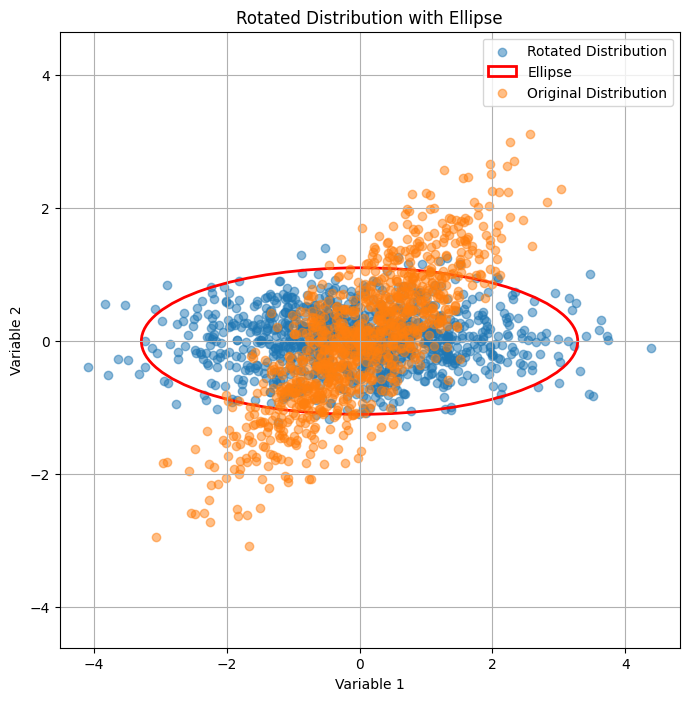

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Generate correlated data
np.random.seed(0)
mean = [0, 0]
covariance = [[1, 0.8], [0.8, 1]]
data = np.random.multivariate_normal(mean, covariance, 1000)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Perform PCA to find principal axes and rotation angle
pca = PCA(n_components=2)
pca.fit(data_scaled)
rotation_angle = np.degrees(np.arctan2(*pca.components_[0][::-1]))

# Rotate the data points
rotation_matrix = np.array([[np.cos(np.radians(rotation_angle)), -np.sin(np.radians(rotation_angle))],
                             [np.sin(np.radians(rotation_angle)), np.cos(np.radians(rotation_angle))]])
rotated_data = np.dot(data_scaled, rotation_matrix)

# Calculate covariance matrix of rotated data
covariance_rotated = np.cov(rotated_data, rowvar=False)

# Calculate eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_rotated)

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Determine rotation angle and scale factors for the ellipse
scale_factor = np.sqrt(-2 * np.log(1 - 0.95))
ellipse_width = scale_factor * np.sqrt(eigenvalues[0])
ellipse_height = scale_factor * np.sqrt(eigenvalues[1])
ellipse_angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

# Plot rotated data points and ellipse
plt.figure(figsize=(8, 8))

# Plot rotated distribution and ellipse
plt.scatter(rotated_data[:, 0], rotated_data[:, 1], alpha=0.5, label='Rotated Distribution')
ellipse = Ellipse((np.mean(rotated_data[:, 0]), np.mean(rotated_data[:, 1])),
                  width=ellipse_width * 2, height=ellipse_height * 2,
                  angle=ellipse_angle, edgecolor='r', fc='None', lw=2, label='Ellipse')
plt.gca().add_patch(ellipse)

# Plot original distribution
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Original Distribution')

plt.title('Rotated Distribution with Ellipse')
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [4]:
data

array([[-1.80006782, -1.54698618],
       [-1.63714503, -0.21987973],
       [-1.46267867, -2.08076347],
       ...,
       [-0.2185878 , -0.15676476],
       [-1.37970304, -1.27950068],
       [ 1.49786804,  0.66873757]])